## Financial Market Analytics Project

In [ ]:
# All imports
import pandas as pd
import numpy as np
from scipy.stats import skew
from datetime import datetime, timedelta
import plotly.express as px
import plotly.io as pio
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cvxpy as cp



### Load data

In this section our dataset is loaded  into a Pandas Dataframe to allow easier and more efficient annalysis. We opted for the S&P500 dataset as it is not only the most widely followed equity index in the world, but it represents approximately 80% of the U.S. market capitalization as well, which in turn dominates global equity markets.

In [2]:
# Read the data, skipping the first row and using the second row as headers
df_sp_m_new = pd.read_excel("../Datasets/SPX500.xlsx", sheet_name="Price", engine="openpyxl", skiprows=[0], header=0)

df_sp_d_new = pd.read_excel("../Datasets/SPX500.xlsx", sheet_name="Price daily", engine="openpyxl", skiprows=[0], header=0)

# Flatten the MultiIndex columns created by read_excel with header=0 and skiprows=[0]
df_sp_m_new.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_sp_m_new.columns]
df_sp_d_new.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_sp_d_new.columns]

print("New df_sp_m head:")
display(df_sp_m_new.head())

New df_sp_m head:


,data,3M Co,Abbott Laboratories,ACME-Cleveland Corp,Advanced Micro Devices Inc,AEP Texas Inc,Aeroquip-Vickers Inc,AIG Life Holdings Inc,Air Products & Chemicals Inc,Alberto-Culver Co,...,Cboe Global Markets Inc.1,United Continental Holdings Inc.1,WellCare Health Plans Inc,Advanced Micro Devices Inc.2,Fortinet Inc,Linde PLC,Rollins Inc,Jack Henry & Associates Inc,Keysight Technologies Inc,Regency Centers Corp.1
0,1990-12-31,20.629,5.0348,4.750,2.4375,22.0000,18.250,7.6875,12.6542,9.5408,...,NaN,NaN,NaN,NaN,NaN,NaN,1.2437,0.1250,NaN,NaN
1,1991-01-31,20.419,4.8810,5.375,3.5625,22.0000,22.000,8.1875,13.6364,9.2897,...,NaN,NaN,NaN,NaN,NaN,NaN,1.2144,0.1667,NaN,NaN
2,1991-02-28,21.291,5.1887,6.625,4.0625,22.0000,24.375,9.1875,14.8499,8.8234,...,NaN,NaN,NaN,NaN,NaN,NaN,1.3242,0.2292,NaN,NaN
3,1991-03-29,21.291,5.3705,6.625,5.1875,22.5625,22.500,9.6250,15.6588,8.5723,...,NaN,NaN,NaN,NaN,NaN,NaN,1.4047,0.2500,NaN,NaN
4,1991-04-30,21.441,5.6642,6.500,6.1250,23.3750,22.125,9.6875,14.4165,7.2452,...,NaN,NaN,NaN,NaN,NaN,NaN,1.4120,0.2986,NaN,NaN


### Skewness
In this step, we filter the dataset to include only the last six months of data, then calculate the percentage of missing values for each stock. We retain only those stocks with no more than 30% missing data (excluding the 'Dates' column). Next, we compute the skewness of returns for the selected stocks, sort them and lastly select the top 20% with the highest skewness value.

In [3]:
# Convert all columns except 'Dates' to numeric, coercing errors
for column in df_sp_d_new.columns:
    if column != 'Dates':
        df_sp_d_new[column] = pd.to_numeric(df_sp_d_new[column], errors='coerce')

# Convert 'Dates' column to datetime objects
df_sp_d_new['Dates'] = pd.to_datetime(df_sp_d_new['Dates'])

# Filter to include only the last 6 months
six_months_ago = df_sp_d_new['Dates'].max() - pd.DateOffset(months=6)
df_sp_d_last_6m_new = df_sp_d_new[df_sp_d_new['Dates'] >= six_months_ago]

# Calculate missing values percentage for each column
missing_percentage_new = df_sp_d_last_6m_new.isnull().mean() * 100

# Select columns with less than or equal to 30% missing values, excluding 'Dates' column
cols_to_analyze_new = missing_percentage_new[missing_percentage_new <= 30].index.tolist()
if 'Dates' in cols_to_analyze_new:
    cols_to_analyze_new.remove('Dates')

# Calculate skewness for the filtered columns
skewness_values_new = df_sp_d_last_6m_new[cols_to_analyze_new].skew()

# Sort skewness values and select the top 20%
top_20_percent_count_new = int(len(skewness_values_new) * 0.2)
top_skewness_new = skewness_values_new.sort_values(ascending=False).head(top_20_percent_count_new)

print("Top 20% titles with highest skewness in the last 6 months:")
print(top_skewness_new)

Top 20% titles with highest skewness in the last 6 months:
Keurig Dr Pepper Inc          1.377693
Edwards Lifesciences Corp     1.291127
Graham Holdings Co            1.289603
Big Lots Inc                  1.251414
McDonald's Corp               1.127863
                                ...   
Wachovia Corp/Old             0.000000
Lexmark International Inc     0.000000
ConocoPhillips Holding Co     0.000000
Burlington Resources Inc      0.000000
CommScope Connectivity LLC    0.000000
Length: 270, dtype: float64


We generate a scatterplot for the skewness for the entire S&P500, and one for the top 20% titles of S&P500 with highest skewness, in the last 6 months to better visualize the data being currently analyzed.

The charts will be opened on the browser for better visibility.

In [4]:
fig = px.scatter(
    x=skewness_values_new.index,
    y=skewness_values_new.values,
    labels={'x': 'Stock', 'y': 'Skewness'},
    title='Skewness of S&P 500 Stocks (Last 6 Months)'
)

pio.renderers.default = 'browser'
fig.show()

fig2 = px.scatter(
    x=top_skewness_new.index,
    y=top_skewness_new.values,
    labels={'x': 'Stock', 'y': 'Skewness'},
    title='Topo 20% Skewness of S&P 500 Stocks (Last 6 Months)'
)

fig2.show()

### Building the momentum portfolio
This section aims to construct a portfolio of the most performing 10 stocks based on the momentum investing strategy.

To compute momentum, we consider the price change over the past 12 months while excluding the most recent month to avoid the short-term reversal effect.
The momentum is computed with the following formula: 

_momentum_values = prices_1m_ago - prices_12m_ago_.

In [5]:
df = df_sp_d_new.copy()
df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
df = df.sort_values(by=df.columns[0])

# Set the date column as an index to facilitate time slicing
df.set_index(df.columns[0], inplace=True)

# Define dates to compute momentum
last_date = df.index.max()
date_1m_ago = last_date - pd.DateOffset(months=1)
date_12m_ago = last_date - pd.DateOffset(months=12)

# Prices closest to 1 month and 12 months ago
prices_1m_ago = df.loc[:date_1m_ago].iloc[-1]
prices_12m_ago = df.loc[:date_12m_ago].iloc[-1]

# Computing momentum for each stock
momentum_values = prices_1m_ago - prices_12m_ago

# Dataframe with stocks and momentum values
momentum = pd.DataFrame({
    'titolo': momentum_values.index,
    'momentum': momentum_values.values
})

# Fixing top_skewness_new
titoli_skew = top_skewness_new.index.tolist()

# Filtering momentum for the titles with high skewness
momentum_filtered = momentum[momentum['titolo'].isin(titoli_skew)]

# Sorting by momentum and selecting the top 10
top10 = momentum_filtered.sort_values(by='momentum', ascending=False).head(10)

print("Top 10 Stocks with higher momentum:")
print(top10)

Top 10 Stocks with higher momentum:
                                 titolo  momentum
1159         Chipotle Mexican Grill Inc  157.3800
1015                      CME Group Inc  126.7250
36        Automatic Data Processing Inc  105.9307
1135               Booking Holdings Inc   96.2900
1077             Intuitive Surgical Inc   91.0400
684       Marriott International Inc/MD   71.6700
1029                IAC/InterActiveCorp   66.0100
1346  United Continental Holdings Inc.1   62.2200
810                          Intuit Inc   45.5800
975                        Intuit Inc.1   45.5800


We then produce a scatterplot illustrating the momentum of the top 20% selected stocks.  

In [6]:
fig3 = px.scatter(
    x=momentum_filtered['titolo'],
    y=momentum_filtered['momentum'],
    labels={'x': 'Stock', 'y': 'Momentum'},
    title='Momentum of Selected S&P 500 Stocks with High Skewness (top20%, lsat 6 months)',
)
fig3.show()

### Comparison with the Markovitz optimal portfolio
Comparing a Markowitz mean-variance optimal portfolio with the momentum-based portfolio is a solid way to validate whether this factor-based method adds value or not.

The portfolio was constructed by creating a weight vector w, which represent the portfolio allocation to each stock, whose total weight sum must be equal to 1 and each one of them must be ≥ 0 (no short selling).

The main objective, as stated by Markovitz, is to maximize expected portfolio return minus a penalty for risk (variance scaled by risk aversion).

Solving this quadratic optimization problem computes the weights that maximize return adjusted for risk, that are then rebalanced in oder to only include the top 25 stocks based on descending weights, so that the built portfolio is more realistic and fucntional (otherwise the optimization problem includes in the optimal portfolio all stocks present in the dataset).


A scatterplot is then created to better visualize the weight distribution in the mean-variance portfolio, in addition to computing the Sharpe Ratio, annual volatility and expected annual return: these metrics all contribute to giving an overall idea of how well the portfolio is performing.

(CVXPY) Jul 01 10:37:40 PM: Your problem has 711 variables, 712 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 01 10:37:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 01 10:37:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 01 10:37:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 01 10:37:41 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 01 10:37:41 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 01 10:37:41 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jul 01 10:37:41 PM: Applying reduction FlipObjective
(CVXPY) Jul 01 10:37:41 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 01 10:37:41 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Jul 01 10:37:41 PM: Applying reduction QpMatrixStuffing
(CVXPY) Jul 01 10:37:42 PM: Applying reduction OSQP
(CVXPY) Jul 01 10:37:42 PM: Finished problem compilation (took 2.008e-01 s

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 711, constraints m = 712
          nnz(P) + nnz(A) = 254538
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-0

(CVXPY) Jul 01 10:37:42 PM: Problem status: optimal
(CVXPY) Jul 01 10:37:42 PM: Optimal value: 1.058e-01
(CVXPY) Jul 01 10:37:42 PM: Compilation took 2.008e-01 seconds
(CVXPY) Jul 01 10:37:42 PM: Solver (including time spent in interface) took 4.498e-01 seconds


 300  -1.0581e-01   8.81e-07   9.43e-06  -1.15e-05   9.43e-06   6.24e-01    3.50e-01s
plsh  -1.0580e-01   8.66e-15   1.02e-13  -3.20e-15   1.02e-13   --------    4.22e-01s

status:               solved
solution polishing:   successful
number of iterations: 300
optimal objective:    -0.1058
dual objective:       -0.1058
duality gap:          -3.2021e-15
primal-dual integral: 2.8885e+01
run time:             4.22e-01s
optimal rho estimate: 7.33e-01

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------

Optimized Markowitz Portfolio (Top 25 Stocks):
                                     Weight  Expected Return
Grumman Corp                       0.108128         0.052230
McDonnell Douglas Corp             0.104763         0.102279
Church & Dwight Co Inc             0.081379         0.159155
Hershey Co/The  

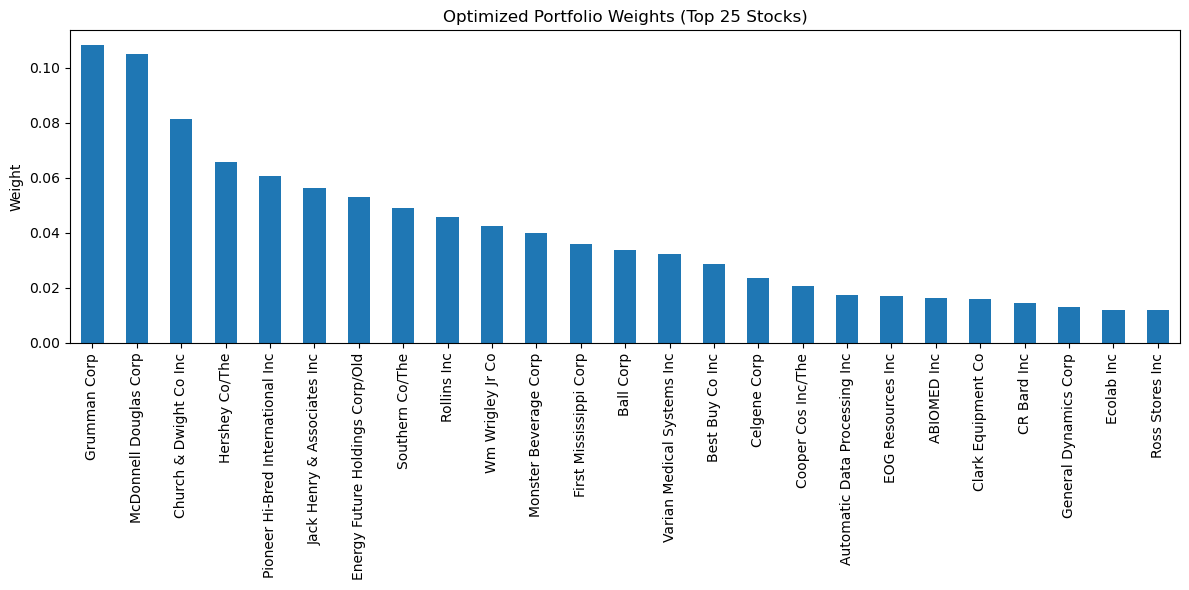

Markowitz Optimal Portfolio (Top 25 assets):
Expected Annual Return: 0.1547
Annual Volatility: 0.0775
Sharpe Ratio: 1.9963


In [ ]:
# --- Data Preparation ---
df_sp_m_new.iloc[:, 0] = pd.to_datetime(df_sp_m_new.iloc[:, 0])
df_sp_m_new.set_index(df_sp_m_new.columns[0], inplace=True)
df_sp_m_new = df_sp_m_new.dropna(axis=1, how='any')
monthly_returns = df_sp_m_new.pct_change().dropna()

# Filter: Keep only stocks with positive average returns
avg_returns = monthly_returns.mean()
monthly_returns = monthly_returns.loc[:, avg_returns > 0]

# --- Compute Annualized Returns & Covariance ---
mean_returns = monthly_returns.mean() * 12
cov_matrix = monthly_returns.cov() * 12
# Add a tiny value to diagonal (1e-6) to ensure matrix is Positive Semi-Definite (PSD), 
# which is a mathematical requirement for optimization
dim = cov_matrix.shape[0]
cov_matrix_psd = cov_matrix + np.eye(dim) * 1e-6

tickers = monthly_returns.columns
n = len(tickers)

# --- cvxpy Variables (without boolean) ---
w = cp.Variable(n)

# --- Objective Function (Mean - Risk Aversion × Variance) ---
risk_aversion = 10
objective = cp.Maximize(mean_returns.values @ w - risk_aversion * cp.quad_form(w, cov_matrix_psd.values))

# --- Constraints ---
constraints = [
    cp.sum(w) == 1,
    w >= 0,
]

# --- Solve the Problem ---
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.OSQP, verbose=True)

# --- Get weights and manually select top 25 ---
weights = pd.Series(w.value, index=tickers)
top_25 = weights.nlargest(25)

# Re-normalize weights to sum to 1
top_25 /= top_25.sum()

# --- Output expected returns for selected assets ---
opt_expected_returns = mean_returns[top_25.index]

# --- Combine into DataFrame ---
opt_portfolio = pd.DataFrame({
    "Weight": top_25,
    "Expected Return": opt_expected_returns
}).sort_values(by="Weight", ascending=False)

# --- Display Results ---
print("\nOptimized Markowitz Portfolio (Top 25 Stocks):")
print(opt_portfolio)

# --- Plot ---
opt_portfolio["Weight"].plot(kind='bar', figsize=(12, 6), title='Optimized Portfolio Weights (Top 25 Stocks)')
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

# --- Portfolio Performance ---
final_weights = top_25.values
mean_selected = mean_returns[top_25.index].values
cov_selected = cov_matrix.loc[top_25.index, top_25.index].values

# Expected return
port_return = np.dot(final_weights, mean_selected)

# Volatility
port_vol = np.sqrt(np.dot(final_weights.T, np.dot(cov_selected, final_weights)))

# Sharpe ratio (risk-free rate = 0)
sharpe_ratio = port_return / port_vol

# --- Print results ---
print("Markowitz Optimal Portfolio (Top 25 assets):")
print(f"Expected Annual Return: {port_return:.4f}")
print(f"Annual Volatility: {port_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


This placement makes sense because:

Your portfolio’s return (~15.5%) is close to the upper end of the frontier’s return range (~18.6% max).

Your portfolio’s risk (~7.75%) is also near the upper end of the frontier’s risk range (~8.96% max).

So your portfolio lies near the high-return, high-risk region, as expected from a Markowitz optimization with a moderate risk aversion (risk_aversion=10).

c:\Users\lucre\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


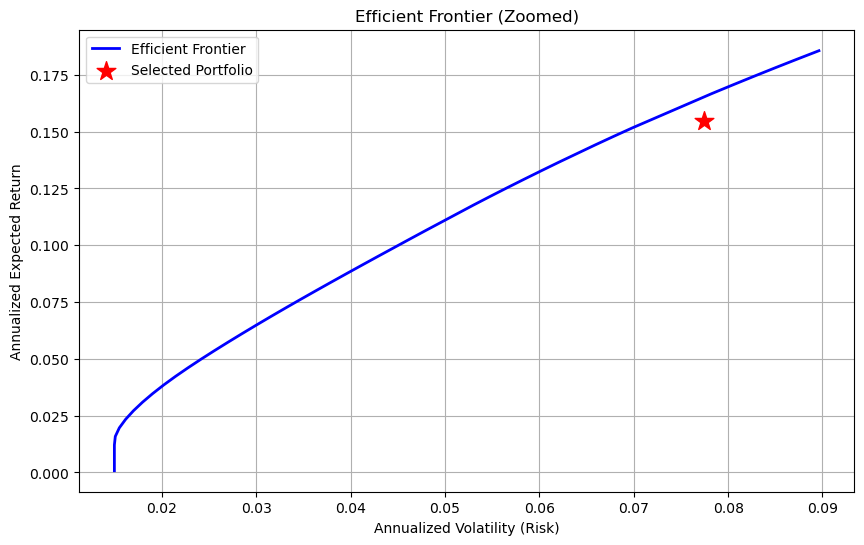

Portfolio return: 0.1547, risk: 0.0775
Efficient frontier return range: 0.0008 - 0.1856
Efficient frontier risk range: 0.0149 - 0.0896


In [8]:
# Restrict target returns range to reasonable upper bound (e.g., 1.2 × portfolio return)
target_returns = np.linspace(mean_returns.min(), port_return * 1.2, 50)
risks = []
weights_list = []

for target in target_returns:
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov_matrix_psd.values))
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mean_returns.values @ w >= target - 1e-4  # small tolerance to improve feasibility
    ]
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(solver=cp.ECOS, verbose=False)
        if w.value is not None and prob.status == cp.OPTIMAL:
            risks.append(np.sqrt(w.value.T @ cov_matrix_psd.values @ w.value))
            weights_list.append(w.value)
        else:
            risks.append(np.nan)
            weights_list.append(None)
    except:
        risks.append(np.nan)
        weights_list.append(None)

# Filter out nan values for plotting
valid_idx = ~np.isnan(risks)
risks = np.array(risks)[valid_idx]
target_returns = target_returns[valid_idx]

# Plot efficient frontier zoomed in with portfolio point
plt.figure(figsize=(10,6))
plt.plot(risks, target_returns, 'b-', lw=2, label='Efficient Frontier')
plt.scatter(port_vol, port_return, color='r', marker='*', s=200, label='Selected Portfolio')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Expected Return')
plt.title('Efficient Frontier (Zoomed)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Portfolio return: {port_return:.4f}, risk: {port_vol:.4f}")
print(f"Efficient frontier return range: {target_returns.min():.4f} - {target_returns.max():.4f}")
print(f"Efficient frontier risk range: {risks.min():.4f} - {risks.max():.4f}")


In [10]:
# Ensure datetime and index
df = df_sp_d_new.copy()
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df.set_index(df.columns[0], inplace=True)
df = df.sort_index()

# Step 1: Get list of top 10 momentum tickers
momentum_tickers = top10['titolo'].tolist()

# Step 2: Extract only those columns
df_top10 = df[momentum_tickers]

# Step 3: Resample to monthly frequency using last trading day of each month
df_top10_monthly = df_top10.resample('M').last()

# Step 4: Compute monthly returns
monthly_returns_top10 = df_top10_monthly.pct_change().dropna()

# (Optional) Show the result
print(monthly_returns_top10.head())


            Chipotle Mexican Grill Inc  CME Group Inc  \
Dates                                                   
2006-03-31                    0.214693       0.051457   
2006-04-30                   -0.057772       0.023464   
2006-05-31                    0.106917      -0.036463   
2006-06-30                    0.055046       0.112962   
2006-07-31                   -0.138638      -0.060979   

            Automatic Data Processing Inc  Booking Holdings Inc  \
Dates                                                             
2006-03-31                      -0.011042              0.011813   
2006-04-30                      -0.035026             -0.016103   
2006-05-31                       0.031533              0.272504   
2006-06-30                      -0.002637             -0.039871   
2006-07-31                      -0.035060             -0.099799   

            Intuitive Surgical Inc  Marriott International Inc/MD  \
Dates                                                        

In [11]:
# Step 1: Lista ticker portafoglio momentum
momentum_tickers = top10['titolo'].tolist()

# Step 2: Pesi uguali per momentum
momentum_weights = np.array([1 / len(momentum_tickers)] * len(momentum_tickers))

# Step 3: Calcolo rendimenti mensili portafoglio momentum
momentum_returns = monthly_returns_top10[momentum_tickers]

momentum_portfolio_series = pd.Series(
    momentum_returns.values @ momentum_weights,
    index=momentum_returns.index,
    name='momentum'
)

# Step 4: Calcolo metriche annualizzate (assumiamo 12 mesi)
momentum_return = momentum_portfolio_series.mean() * 12
momentum_volatility = momentum_portfolio_series.std() * np.sqrt(12)
momentum_sharpe = momentum_return / momentum_volatility

# Output
print("\nMomentum Portfolio:")
print(f"Expected Annual Return: {momentum_return:.4f}")
print(f"Annual Volatility: {momentum_volatility:.4f}")
print(f"Sharpe Ratio: {momentum_sharpe:.4f}")



Momentum Portfolio:
Expected Annual Return: 0.2457
Annual Volatility: 0.2668
Sharpe Ratio: 0.9209


In [12]:
# Controlla e imposta l'indice come DatetimeIndex
df_sp_m_new[df_sp_m_new.columns[0]] = pd.to_datetime(df_sp_m_new[df_sp_m_new.columns[0]])
df_sp_m_new.set_index(df_sp_m_new.columns[0], inplace=True)

# Calcolo rendimenti mensili semplici
monthly_returns = df_sp_m_new.pct_change().dropna()

# Ora l'indice deve essere DatetimeIndex
print(type(monthly_returns.index))  # deve stampare <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

# Se è DatetimeIndex, puoi prendere gli ultimi 12 mesi con .last()
end_date = monthly_returns.index.max()
start_date = end_date - pd.DateOffset(months=12)

last_12_months = monthly_returns.loc[(monthly_returns.index > start_date) & (monthly_returns.index <= end_date)]

# Segue come prima
n_tickers = last_12_months.shape[1]
weights = np.array([1 / n_tickers] * n_tickers)

portfolio_returns = last_12_months.values @ weights
portfolio_returns = pd.Series(portfolio_returns, index=last_12_months.index)

expected_annual_return = portfolio_returns.mean() * 12
annual_volatility = portfolio_returns.std() * np.sqrt(12)
sharpe_ratio = expected_annual_return / annual_volatility

print("Sharpe Ratio ultimo anno (portafoglio equal-weight S&P500):")
print(f"Expected Annual Return: {expected_annual_return:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Sharpe Ratio ultimo anno (portafoglio equal-weight S&P500):
Expected Annual Return: 0.1486
Annual Volatility: 0.1859
Sharpe Ratio: 0.7991


C:\Users\lucre\AppData\Local\Temp\ipykernel_17896\3536269101.py:13: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [13]:

# Step 0: Assicurati che la colonna data sia indice di tipo DatetimeIndex
df_sp_m_new[df_sp_m_new.columns[0]] = pd.to_datetime(df_sp_m_new[df_sp_m_new.columns[0]])
df_sp_m_new.set_index(df_sp_m_new.columns[0], inplace=True)

# Step 1: Lista ticker portafoglio momentum
momentum_tickers = top10['titolo'].tolist()

# Step 2: Pesi uguali per momentum
momentum_weights = np.array([1 / len(momentum_tickers)] * len(momentum_tickers))

# Step 3: Calcolo rendimenti mensili per TUTTO il periodo disponibile
# Calcolo rendimenti percentuali mensili semplici
monthly_returns = df_sp_m_new.pct_change().dropna()

# Filtra solo i ticker del portafoglio momentum (attenzione a ticker mancanti)
momentum_tickers_filtered = [t for t in momentum_tickers if t in monthly_returns.columns]
momentum_returns = monthly_returns[momentum_tickers_filtered]

# Step 4: Calcolo rendimento mensile portafoglio momentum (weighted average)
momentum_portfolio_series = pd.Series(
    momentum_returns.values @ momentum_weights[:len(momentum_tickers_filtered)],
    index=momentum_returns.index,
    name='momentum'
)

# Step 5: Calcolo metriche annualizzate (assumiamo 12 mesi/anno)
momentum_return = momentum_portfolio_series.mean() * 12
momentum_volatility = momentum_portfolio_series.std() * np.sqrt(12)
momentum_sharpe = momentum_return / momentum_volatility

# Output
print("\nMomentum Portfolio su periodo completo:")
print(f"Expected Annual Return: {momentum_return:.4f}")
print(f"Annual Volatility: {momentum_volatility:.4f}")
print(f"Sharpe Ratio: {momentum_sharpe:.4f}")



Momentum Portfolio su periodo completo:
Expected Annual Return: 0.0188
Annual Volatility: 0.0561
Sharpe Ratio: 0.3350


Markowitz Optimal Portfolio:
Expected Annual Return: 0.1126
Annual Volatility: 0.0507
Sharpe Ratio: 2.2195

Selected Stock Weights (> 1%):
Grumman Corp                         0.096590
CBS Broadcasting Inc                 0.078834
McDonnell Douglas Corp               0.067059
Cross & Trecker Corp                 0.054735
Church & Dwight Co Inc               0.043076
Florida Progress Corp                0.041245
First Mississippi Corp               0.040218
Pioneer Hi-Bred International Inc    0.038612
Energy Future Holdings Corp/Old      0.035704
Blockbuster Entertainment Corp       0.032957
Hershey Co/The                       0.032129
USLIFE Corp                          0.029038
Rollins Inc                          0.027520
Southern Co/The                      0.026723
Gerber Products Co                   0.025578
Paramount Communications Inc         0.019564
Monster Beverage Corp                0.019035
Hormel Foods Corp                    0.018113
Jack Henry & Associates Inc      

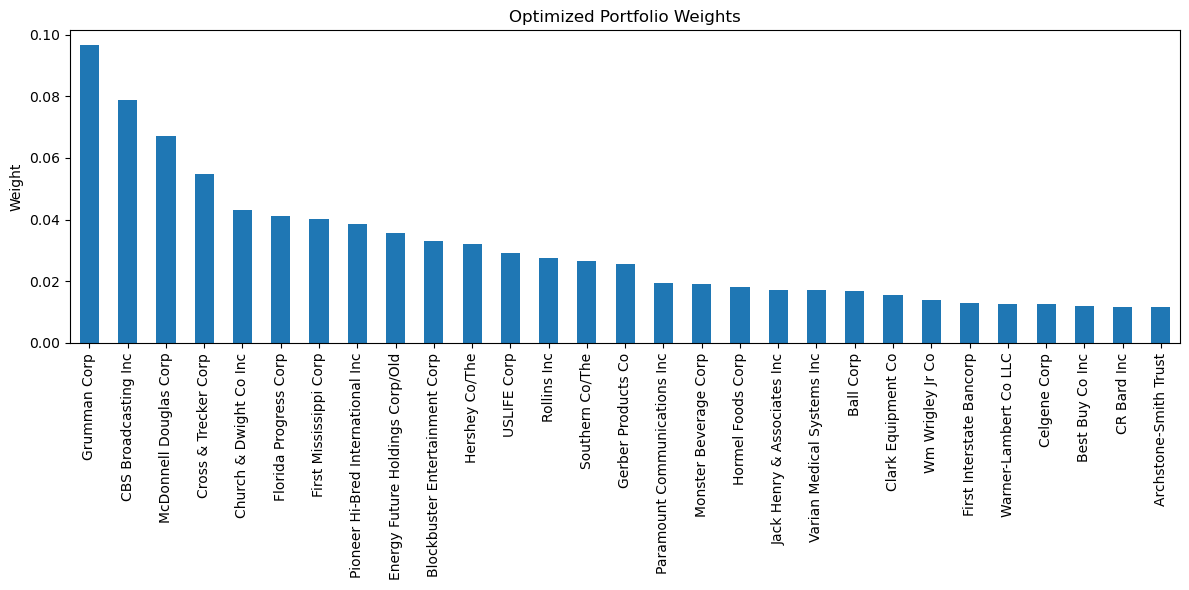

In [14]:
# --- Step 1: Preprocessing dataframe ---

# Copia per sicurezza
df = df_sp_m_new.copy()

# Converto prima colonna in datetime
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])

# Imposto la prima colonna come indice
df.set_index(df.columns[0], inplace=True)

# Rimuovo colonne con valori NaN (se ci sono)
df.dropna(axis=1, how='any', inplace=True)

# --- Step 2: Calcolo rendimenti mensili semplici ---
monthly_returns = df.pct_change().dropna()

# --- Step 3: Filtra titoli con rendimento medio positivo ---
avg_returns = monthly_returns.mean()
monthly_returns = monthly_returns.loc[:, avg_returns > 0]

# --- Step 4: Calcolo medie e covarianza ---
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()

# --- Step 5: Funzioni per calcolare statistiche portafoglio ---
def portfolio_stats(weights):
    port_return = np.dot(weights, mean_returns) * 12  # annualizzato
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))  # annualizzato
    sharpe = port_return / port_vol
    return port_return, port_vol, sharpe

def neg_sharpe_ratio(weights):
    return -portfolio_stats(weights)[2]

# --- Step 6: Constraints e bounds ---
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(monthly_returns.columns)))

# --- Step 7: Inizializzo pesi uguali ---
initial_weights = np.array([1 / len(monthly_returns.columns)] * len(monthly_returns.columns))

# --- Step 8: Ottimizzazione ---
opt_result = minimize(neg_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# --- Step 9: Risultati ---
opt_weights = opt_result.x
port_return, port_vol, sharpe_ratio = portfolio_stats(opt_weights)

print("Markowitz Optimal Portfolio:")
print(f"Expected Annual Return: {port_return:.4f}")
print(f"Annual Volatility: {port_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# Pesi > 1%
opt_portfolio = pd.Series(opt_weights, index=monthly_returns.columns)
opt_portfolio = opt_portfolio[opt_portfolio > 0.01].sort_values(ascending=False)

print("\nSelected Stock Weights (> 1%):")
print(opt_portfolio)

# --- Step 10: Plot ---
opt_portfolio.plot(kind='bar', figsize=(12, 6), title='Optimized Portfolio Weights')
plt.ylabel("Weight")
plt.tight_layout()
plt.show()


In [15]:
# Copia del dataframe originale
df = df_sp_m_new.copy()

# Converto la prima colonna in datetime e la imposto come indice
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df.set_index(df.columns[0], inplace=True)

# Rimuovo colonne con valori NaN (se ce ne sono)
df.dropna(axis=1, how='any', inplace=True)

# Calcolo rendimenti mensili semplici
monthly_returns = df.pct_change().dropna()

# Numero titoli
n_tickers = monthly_returns.shape[1]

# Pesi uguali per ogni titolo
weights = np.array([1 / n_tickers] * n_tickers)

# Calcolo rendimento mensile del portafoglio
portfolio_returns = monthly_returns.values @ weights

# Creo una serie per comodità
portfolio_returns = pd.Series(portfolio_returns, index=monthly_returns.index)

# Calcolo metriche annualizzate (12 mesi)
expected_annual_return = portfolio_returns.mean() * 12
annual_volatility = portfolio_returns.std() * np.sqrt(12)
sharpe_ratio = expected_annual_return / annual_volatility

print("Equal-weight S&P500 Portfolio (1990-2018):")
print(f"Expected Annual Return: {expected_annual_return:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Equal-weight S&P500 Portfolio (1990-2018):
Expected Annual Return: 0.1487
Annual Volatility: 0.1863
Sharpe Ratio: 0.7979


### Drawdown

In [18]:
# Momentum drawdown
cumulative_returns = (1 + momentum_portfolio_series).cumprod()

running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max

max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")



Maximum Drawdown: -6.55%


In [19]:
# Sharp ratio portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()

running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max

max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")


Maximum Drawdown: -33.44%


### Rebalancing the momentum investing stategy portfolio

In [ ]:
# 1. Resample daily prices to monthly (last trading day of each month)
df_sp_d_new.iloc[:, 0] = pd.to_datetime(df_sp_d_new.iloc[:, 0])  # Convert first column to datetime
df_sp_d_new.set_index(df_sp_d_new.columns[0], inplace=True)      # Set as index

monthly_prices = df_sp_d_new.resample('M').last()

# 2. Define function to calculate momentum (12-month return, skip last month)
def calculate_momentum(prices, lookback=12, skip=1):
    return prices.shift(skip).pct_change(lookback)

# 3. Parameters
top_n = 10
momentum_window = 12
skip_last_month = 1
rebalance_dates = monthly_prices.index

# 4. Store monthly portfolio returns
portfolio_returns = []

# 5. Rebalance each month
for i in range(momentum_window + skip_last_month, len(monthly_prices) - 1):
    # Current date and next date
    current_date = rebalance_dates[i]
    next_date = rebalance_dates[i + 1]

    # Slice momentum calculation window
    momentum_df = calculate_momentum(monthly_prices.iloc[:i+1], 
                                     lookback=momentum_window, 
                                     skip=skip_last_month)
    
    # Get momentum values for current rebalance date
    momentum_values = momentum_df.loc[current_date].dropna()

    # Select top N stocks
    top_stocks = momentum_values.sort_values(ascending=False).head(top_n).index.tolist()

    # Equal weights
    weights = np.array([1 / top_n] * top_n)

    # Calculate portfolio return from current_date to next_date
    prices_now = monthly_prices.loc[current_date, top_stocks]
    prices_next = monthly_prices.loc[next_date, top_stocks]
    returns = (prices_next - prices_now) / prices_now

    portfolio_return = np.dot(weights, returns)
    portfolio_returns.append((next_date, portfolio_return))

# 6. Convert to DataFrame
momentum_portfolio_series = pd.Series(
    data=[ret for _, ret in portfolio_returns],
    index=[date for date, _ in portfolio_returns],
    name='MomentumPortfolio'
)


C:\Users\lucre\AppData\Local\Temp\ipykernel_12880\1394038137.py:12: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\lucre\AppData\Local\Temp\ipykernel_12880\1394038137.py:12: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\lucre\AppData\Local\Temp\ipykernel_12880\1394038137.py:12: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\lucre\AppData\Local\Temp\ipykernel_12880\13

Maximum Drawdown: -61.19%


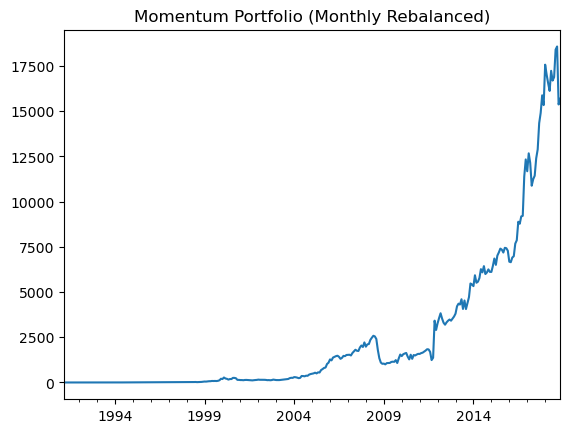

In [25]:
cumulative_returns = (1 + momentum_portfolio_series).cumprod()
cumulative_returns.plot(title="Momentum Portfolio (Monthly Rebalanced)")

# Drawdown
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

